# Object detection with TensorFlow Object Detection API (version 4)
Train your own dataset using transfer learning and [TF object detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

Previous [version 3](https://colab.research.google.com/drive/1Pdc3K4wjmSjQM6SEc0YeI_X7TK7KoDfO) used dataset from a repository.

## Step 1. Create dataset and annotate images
20 images can be enough with each image containing multiple objects. Each image comes with 4032×3024 resolution. It'll overwhelm the model if we use that as direct input to the model. Instead, resize those photos to uniformed size (800, 600) can make training and inference faster. Use the [`resize_images.py`](https://github.com/foobar167/junkyard/blob/master/simple_scripts/resize_images.py) script in the repository to resize your images.

Annotate resized images with [LabelImg](https://tzutalin.github.io/labelImg), this annotation tool supports both Windows and Linux, it will generate `xml` files inside `./data/images/train` and `./data/images/test` directories. Tip: use shortcuts (`w`: draw box, `d`: next file, `a`: previous file, etc.) to accelerate the annotation.

## Step 2. Prepare Colab

### Enable GPU acceleration and Python 3.

Set GPU hardware acceleration in menu: `Runtime --> Change runtime type --> Hardware accelerator --> GPU --> Save`.

Set Python 3 in menu: `Runtime --> Change runtime type --> Runtime type --> Python 3 --> Save`.

In [0]:
# Downgrade TensorFlow to version 1.x,
# because version 2.0 has no attribute 'contrib'.
# For the 1.15 release, CPU and GPU support are included in a single package.
!pip -q install tensorflow==1.15

# Check it
import sys
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
elif sys.version_info.major < 3:
    raise SystemError('Python 2.7 is out of date now')
else:
    print('OK. TF version:', tf.__version__)

OK. TF version: 1.15.0


### Set configs and hyperparameters
Support for various models, you can find more pre-trained models in [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [0]:
# If you forked the repository, you can replace this link
repo_url = 'https://github.com/foobar167/object_detection_demo'

# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

### Clone the `object_detection_demo` repository or your fork

In [0]:
import os
import shutil

# Create project directory and clone repo into it
project_dir =  os.path.join(os.path.sep, 'content', 'project')
repo_dir = os.path.join(project_dir, os.path.basename(repo_url))

if not os.path.exists(project_dir):  # create project dir if not exists
    os.makedirs(project_dir)

%cd '{project_dir}'

if os.path.exists(repo_dir):  # remove repo dir if exists
    shutil.rmtree(repo_dir)

!git clone '{repo_url}'

/content/project
Cloning into 'object_detection_demo'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 11.16 MiB | 6.16 MiB/s, done.
Resolving deltas: 100% (55/55), done.


### Install required packages

In [0]:
# Install protoc compiler and lxml
!apt install -qq protobuf-compiler python-lxml

# Install cython, contextlib2, pillow, matplotlib and pycocotools
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [0]:
%cd '{project_dir}'

# Clone TensorFlow models
!git clone --quiet https://github.com/tensorflow/models.git

/content/project


In [0]:
research_dir = os.path.join(project_dir, 'models', 'research')
object_detection_dir = os.path.join(research_dir, 'object_detection')

%cd '{research_dir}'

# Compile the object detection library using protoc compiler.
# Protoc is a compiler for protocol buffers definitions files.
# It can can generate C++, Java and Python source code
# for the classes defined in PROTO_FILE.
# Compile the proto files to Python files.
!protoc object_detection/protos/*.proto --python_out=.

# Add research and slim directories to the environment path.
os.environ['PYTHONPATH'] += ':' + research_dir
os.environ['PYTHONPATH'] += ':' + os.path.join(research_dir, 'slim')

# Run unit test. Must be 'OK' at the end of the output.
!python object_detection/builders/model_builder_test.py

/content/project/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.8: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcn

## Step 3. Prepare TFRecord files
The `tfrecord` file format is easier to use and faster to load during the training phase compared to storing each image and annotation separately.

At the end of this step, you will have two files `train.record` and `test.record`, both are binary files with each one containing the encoded JPG and bounding box annotation information for the corresponding train/test set.

To make TFRecord files:
   * convert individual `*.xml` files with annotations to one unified `*.csv` file for both train and test sets;
   * convert `*.csv` and image files of each train and test sets to `*.record` files (TFRecord format).

In [0]:
# Go to repository directory
%cd {repo_dir}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python xml_to_csv.py -i data/images/train \
                      -o data/annotations/train_labels.csv \
                      -l data/annotations

# Convert test folder annotation xml files to a single csv.
!python xml_to_csv.py -i data/images/test \
                      -o data/annotations/test_labels.csv

# Generate `train.record` file
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv \
                             --output_path=data/annotations/train.record \
                             --img_path=data/images/train \
                             --label_map data/annotations/label_map.pbtxt

# Generate `test.record` file
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv \
                             --output_path=data/annotations/test.record \
                             --img_path=data/images/test \
                             --label_map data/annotations/label_map.pbtxt


/content/project/object_detection_demo
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W1024 11:15:04.731689 140300373817216 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1024 11:15:04.743181 140300373817216 module_wrapper.py:139] From /content/project/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/project/object_detection_demo/data/annotations/train.record


W1024 11:15:08.299925 140081550333824 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1024 11:15:08.309772 140081550333824 module_wrapper.py:139] From /content/project/models/research/object_detection/utils/label_map_util.py:1

In [0]:
# Save file names of TFRecord and pbtxt files
test_record_fname     = os.path.join(repo_dir, 'data', 'annotations', 'test.record')
train_record_fname    = os.path.join(repo_dir, 'data', 'annotations', 'train.record')
label_map_pbtxt_fname = os.path.join(repo_dir, 'data', 'annotations', 'label_map.pbtxt')

# Check it
!ls -hal '{test_record_fname}' '{train_record_fname}' '{label_map_pbtxt_fname}'

-rw-r--r-- 1 root root  112 Oct 24 11:14 /content/project/object_detection_demo/data/annotations/label_map.pbtxt
-rw-r--r-- 1 root root 470K Oct 24 11:15 /content/project/object_detection_demo/data/annotations/test.record
-rw-r--r-- 1 root root 4.0M Oct 24 11:15 /content/project/object_detection_demo/data/annotations/train.record


## Step 4. Prepare for transfer learning
Instead of training the model from scratch, we'll do **transfer learning** from a pre-trained model to detect everyday objects.

Transfer learning requires less training data compared to training from scratch.

However keep in mind that transfer learning technique supposes your training data be somewhat similar to the data used to train the base pre-trained model. In our case, the base model is trained with [coco dataset](http://cocodataset.org) of common objects. 3 target objects we want to train the model to detect are fruits and nuts: **date fruit**, **figs** and **hazelnut**. They are similar to ones in coco datasets. On the other hand, if your target objects are lung nodules in CT images, transfer learning might not work so well since they are entirely different compared to coco dataset common objects. In that case, you probably need to train the model from scratch with much more annotations.

To do the transfer learning training, we must download pre-trained model weights and checkpoints. Then prepare the corresponding pipeline config file.

### Download pre-trained base model

In [0]:
# Change directory to research models from TensorFlow
%cd {research_dir}

import os
import shutil
import glob
import urllib.request
import tarfile

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = os.path.join(research_dir, 'pretrained_model')

# Download base model file
if not os.path.exists(MODEL_FILE):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# Unzip model file
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# Remove zipped model file
os.remove(MODEL_FILE)

# Rename (move) directory
if os.path.exists(DEST_DIR):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/project/models/research


In [0]:
# Check it
!echo '{DEST_DIR}'
!ls -hal '{DEST_DIR}'

/content/project/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 70 root   root  4.0K Oct 24 11:21 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [0]:
# Set path to pre-trained model checkpoint file
fine_tune_checkpoint = os.path.join(DEST_DIR, 'model.ckpt')
print(fine_tune_checkpoint)

/content/project/models/research/pretrained_model/model.ckpt


### Configure training pipeline
Prepare the configuration file. We must provide the trainer configuration file with the following information:
   * path to pre-trained model checkpoint file (`fine_tune_checkpoint`);
   * path to `train.record` and `test.record` TFRecord files;
   * path to the `label_map.pbtxt` file (`label_map_path`);
   * training batch size (`batch_size`);
   * number of training steps (`num_steps`);
   * number of classes of unique objects (`num_classes`).

See the example of [ssd_mobilenet_v2_coco.config](https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config) configuration file.

In [0]:
import os

pipeline_fname = os.path.join(object_detection_dir, 'samples', 'configs', pipeline_file)

assert os.path.isfile(pipeline_fname), 'File `{}` does not exist'.format(pipeline_fname)

In [0]:
# Get number of classes of unique objects
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [0]:
# Use regular expressions to modify config file
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()

with open(pipeline_fname, 'w') as f:
    # Set path to pre-trained model checkpoint file (fine_tune_checkpoint)
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set path to train.record and test.record TFRecord files
    s = re.sub('(input_path: ".*?)(train.record)(.*?")',
               'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub('(input_path: ".*?)(val.record)(.*?")',
               'input_path: "{}"'.format(test_record_fname), s)

    # Set path to the label_map.pbtxt file (label_map_path)
    s = re.sub('label_map_path: ".*?"',
               'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch size (batch_size)
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set number of training steps (num_steps)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes of unique objects (num_classes)
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    f.write(s)

In [0]:
# Check it
!cat '{pipeline_fname}'

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

## Step 5. Run TensorBoard (optional) and train the model

### Set `model_dir` path to store the output model

In [0]:
# Set `model_dir` path to store the output model
model_dir = os.path.join(project_dir, 'trained_model')

# Remove previous content and create the empty directory
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)
os.makedirs(model_dir, exist_ok=True)

### Run TensorBoard (optional)
Start TensorBoard before training to monitor it in progress.

#### Install [`ngrok`](https://ngrok.com)

`ngrok` exposes local servers behind NATs and firewalls to the public Internet over secure tunnels.

How `ngrok` works. You [download](https://ngrok.com/download) and run a program on your machine and provide it the port of a network service, usually a web server. It connects to the ngrok cloud service which accepts traffic on a public address and relays that traffic through to the ngrok process running on your machine and then on to the local address you specified. 

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-10-24 11:35:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.61.249, 35.170.171.200, 52.23.2.88, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.61.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.61MB/s    in 2.0s    

2019-10-24 11:35:26 (6.61 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


#### Run TensorBoard and ngrok ([link](https://adventuresinmachinelearning.com/introduction-to-google-colaboratory/))

The `get_ipython()` command allows one to access IPython commands, and `system_raw()` executes commands in the native command prompt / terminal. The string argument passed to `system_raw()` starts a TensorBoard session which searches for log files in LOG_DIR, and runs on port 6006.

The curl command in Linux is used to run http requests. In this case, a request is being made to `http://localhost:4040/api/tunnels`. This is an ngrok API running locally that contains information about the tunnels that are operating.

The information received from that curl http request is then sent to the local Python 3 application via the Linux pipe `|` operator. The results come into Python via `sys.stdin` in json format – and the public URL of the tunnel that has been created is printed to screen. Running this command will return an URL in Google Colaboratory that looks something like: `https://712a59dd.ngrok.io`

Clicking on the link in Google Colaboratory will send your browser to your TensorBoard portal. So now you can use TensorBoard in Google Colaboratory – which is very handy.

In [0]:
# Set logging directory
LOG_DIR = model_dir

# Create a TensorBoard session in the usual way to port 6006.
get_ipython().system_raw(
    'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

In [0]:
# Start the ngrok tunnel via the http protocol to port 6006.
# The same port that TensorBoard can be accessed from.
get_ipython().system_raw('./ngrok http 6006 &')

# Print out the link which will take the user to the TensorBoard portal
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://bafa047a.ngrok.io


### Train the model

In [0]:
!python "{os.path.join(object_detection_dir, 'model_main.py')}" \
    --pipeline_config_path='{pipeline_fname}' \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1024 11:36:56.314129 139748120278912 module_wrapper.py:139] From /content/project/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1024 11:36:56.317576 139748120278912 module_wrapper.py:139] From /content/project/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1024 11:36:56.317727 139748120278912 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W1024 11:36:56.317916 139748120278912 module_wrapper.py:139] From /co

In [0]:
# Check it
!ls -hal '{model_dir}'

total 201M
drwxr-xr-x 4 root root 4.0K Oct 24 11:45 .
drwxr-xr-x 5 root root 4.0K Oct 24 11:34 ..
-rw-r--r-- 1 root root  130 Oct 24 11:45 checkpoint
drwxr-xr-x 2 root root 4.0K Oct 24 11:45 eval_0
-rw-r--r-- 1 root root  28M Oct 24 11:45 events.out.tfevents.1571917055.252a9b231fc2
drwxr-xr-x 3 root root 4.0K Oct 24 11:45 export
-rw-r--r-- 1 root root  16M Oct 24 11:37 graph.pbtxt
-rw-r--r-- 1 root root  72M Oct 24 11:37 model.ckpt-0.data-00000-of-00001
-rw-r--r-- 1 root root  41K Oct 24 11:37 model.ckpt-0.index
-rw-r--r-- 1 root root 7.9M Oct 24 11:37 model.ckpt-0.meta
-rw-r--r-- 1 root root  72M Oct 24 11:45 model.ckpt-1000.data-00000-of-00001
-rw-r--r-- 1 root root  41K Oct 24 11:45 model.ckpt-1000.index
-rw-r--r-- 1 root root 7.9M Oct 24 11:45 model.ckpt-1000.meta


In [0]:
# Legacy way of training. Also works, but I didn't check it.
"""
!python "{os.path.join(object_detection_dir, 'legacy', 'train.py')}" \
    --logtostderr \
    --train_dir='{model_dir}' \
    --pipeline_config_path='{pipeline_fname}'
"""

'\n!python "{os.path.join(object_detection_dir, \'legacy\', \'train.py\')}"     --logtostderr     --train_dir=\'{model_dir}\'     --pipeline_config_path=\'{pipeline_fname}\'\n'

## Step 6. Export and download a trained model

### Extract an inference graph
Once your training task is complete, you need to extract the newly trained model as an inference graph, which will be used later to perform an object detection.

In [0]:
import os
import re
import numpy as np

output_directory = os.path.join(project_dir, 'fine_tuned_model')

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps = np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

!python "{os.path.join(object_detection_dir, 'export_inference_graph.py')}" \
    --input_type=image_tensor \
    --pipeline_config_path='{pipeline_fname}' \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'


/content/project/trained_model/model.ckpt-1000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1024 11:48:23.147499 139620984248192 module_wrapper.py:139] From /content/project/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1024 11:48:23.153949 139620984248192 module_wrapper.py:139] From /content/project/models/research/object_detection/exporter.py:389: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1024 11:48:23.154345 139620984248192 module_wrapper.py:139] From /content/project/models/research/object_detection/exporter.py:121: The name

In [0]:
# Check it
!ls -hal '{output_directory}'

total 38M
drwxr-xr-x 3 root root 4.0K Oct 24 11:48 .
drwxr-xr-x 6 root root 4.0K Oct 24 11:48 ..
-rw-r--r-- 1 root root   77 Oct 24 11:48 checkpoint
-rw-r--r-- 1 root root  19M Oct 24 11:48 frozen_inference_graph.pb
-rw-r--r-- 1 root root  18M Oct 24 11:48 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root  14K Oct 24 11:48 model.ckpt.index
-rw-r--r-- 1 root root 1.4M Oct 24 11:48 model.ckpt.meta
-rw-r--r-- 1 root root 4.1K Oct 24 11:48 pipeline.config
drwxr-xr-x 3 root root 4.0K Oct 24 11:48 saved_model


In [0]:
# Get .pb file path
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), 'File `{}` does not exist'.format(pb_fname)

!ls -alh '{pb_fname}'

-rw-r--r-- 1 root root 19M Oct 24 11:48 /content/project/fine_tuned_model/frozen_inference_graph.pb


## Step 7. Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [0]:
import os
import glob

# Path to frozen detection graph.
# This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images,
# just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir, 'test')

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(
    PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/project/object_detection_demo/test/0.jpg', '/content/project/object_detection_demo/test/10.jpg', '/content/project/object_detection_demo/test/15.jpg']


Run this script **twice**. For the first time there will be no image output.

/content/project/models/research/object_detection


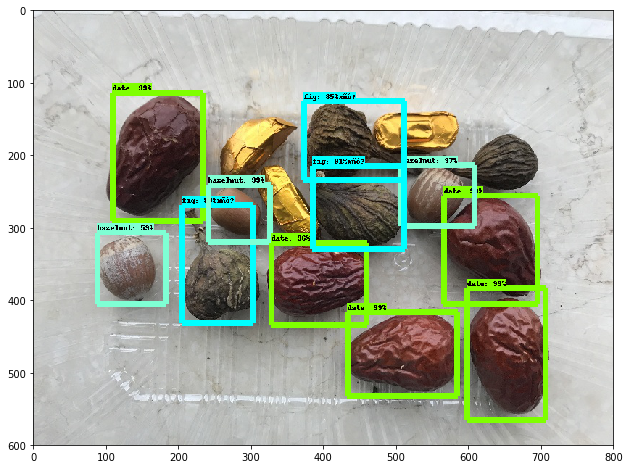

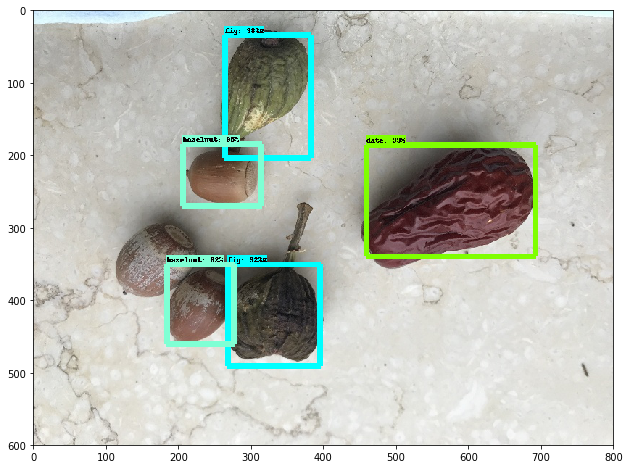

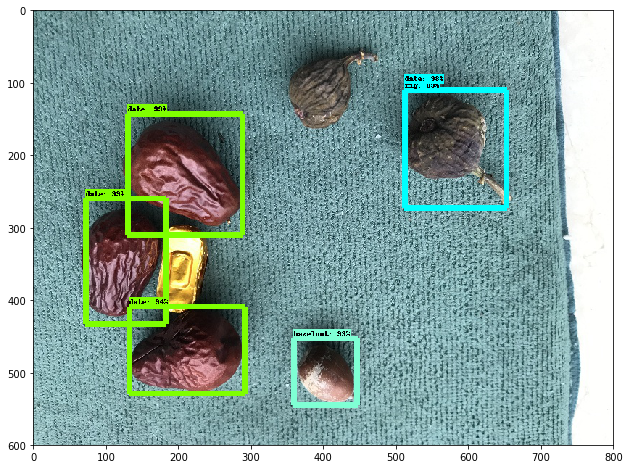

In [0]:
%cd '{object_detection_dir}'

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates
                # to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0],
                                           [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0],
                                           [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # All outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # The array based representation of the image will be used later
    # in order to prepare the result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Step 8. Get files for TensorFlow Lite
Documentation is here: [Running on mobile with TensorFlow Lite](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tensorflowlite.md)

Make sure not to confuse `export_tflite_ssd_graph` with `export_inference_graph` in the same directory. Both scripts output frozen graphs: `export_tflite_ssd_graph` will output the frozen graph that we can input to TensorFlow Lite directly and is the one we’ll be using.

In [0]:
# Create necessary path names again.
project_dir =  os.path.join(os.path.sep, 'content', 'project')
model_dir = os.path.join(project_dir, 'trained_model')
research_dir = os.path.join(project_dir, 'models', 'research')
object_detection_dir = os.path.join(research_dir, 'object_detection')

# Config file name: ssd_mobilenet_v2_coco.config
pipeline_fname = os.path.join(object_detection_dir, 'samples', 'configs', pipeline_file)

# Install protoc compiler and lxml
!apt install -qq protobuf-compiler python-lxml

# Install cython, contextlib2, pillow, matplotlib and pycocotools
!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools

%cd {research_dir}

# You already compiled files with `protoc` compiler

# Add research and slim directories to the environment path.
os.environ['PYTHONPATH'] += ':' + research_dir
os.environ['PYTHONPATH'] += ':' + os.path.join(research_dir, 'slim')

# Run unit test again
!python object_detection/builders/model_builder_test.py

protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
/content/project/models/research
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.8: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcn

In [0]:
# Get frozen graph for TF Lite
import os
import re
import numpy as np

tflite_dir = os.path.join(project_dir, 'tflite_model')

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps = np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

!python "{os.path.join(object_detection_dir, 'export_tflite_ssd_graph.py')}" \
    --pipeline_config_path='{pipeline_fname}' \
    --trained_checkpoint_prefix='{last_model_path}' \
    --output_directory='{tflite_dir}' \
    --add_postprocessing_op=true


/content/project/trained_model/model.ckpt-1000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1024 12:07:57.428384 139933182052224 module_wrapper.py:139] From /content/project/models/research/object_detection/export_tflite_ssd_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1024 12:07:57.432810 139933182052224 module_wrapper.py:139] From /content/project/models/research/object_detection/export_tflite_ssd_graph_lib.py:193: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1024 12:07:57.433241 139933182052224 module_wrapper.py:139] From /content/project/models/research/object_detection/expor

In [0]:
# Check 2 files: tflite_graph.pb and tflite_graph.pbtxt
!ls -hal '{tflite_dir}'

total 69M
drwxr-xr-x 2 root root 4.0K Oct 24 12:08 .
drwxr-xr-x 7 root root 4.0K Oct 24 12:07 ..
-rw-r--r-- 1 root root  19M Oct 24 12:08 tflite_graph.pb
-rw-r--r-- 1 root root  51M Oct 24 12:08 tflite_graph.pbtxt


Convert the resulting frozen graph `tflite_graph.pb` to the TensorFlow Lite flatbuffer format `detect.tflite`.

Do not use `bazel` [TOCO](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/toco) (the <u>**T**</u>ensorflow lite <u>**O**</u>ptimizing <u>**CO**</u>nverter) to do this, but the [`tflite_convert`](https://www.tensorflow.org/lite/convert/cmdline_examples) utility which is the part of tensorflow 1.10 (or higher) package.

Setting the **input_array** and **output_array** arguments is not straightforward. The easiest way to find these values is to explore the graph using TensorBoard.

In [0]:
# Set paths and variables for conversion
graph_def_file = os.path.join(tflite_dir, 'tflite_graph.pb')
output_file = os.path.join(tflite_dir, 'detect.tflite')
input_arrays = ['normalized_input_image_tensor']
output_arrays = ['TFLite_Detection_PostProcess',
                 'TFLite_Detection_PostProcess:1',
                 'TFLite_Detection_PostProcess:2',
                 'TFLite_Detection_PostProcess:3']
input_shapes = {'normalized_input_image_tensor': (1, 300, 300, 3)}

In [0]:
# Get input and output arrays from the graph.
import tensorflow as tf

gf = tf.GraphDef()   
m_file = open(graph_def_file, 'rb')
gf.ParseFromString(m_file.read())

with open('somefile.txt', 'a') as the_file:
    for n in gf.node:
        the_file.write(n.name+'\n')

file = open('somefile.txt', 'r')
data = file.readlines()
print("output array = {}".format(data[len(data)-1]))
file.seek(0)
print("input array = {}".format(file.readline()))

output array = TFLite_Detection_PostProcess

input array = normalized_input_image_tensor



In [0]:
# Convert frozen graph `tflite_graph.pb file` to the
# TF Lite flatbuffer format `detect.tflite` file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_frozen_graph(
        graph_def_file=graph_def_file,
        input_arrays=input_arrays,
        output_arrays=output_arrays,
        input_shapes=input_shapes)

# Option `ops` is for TF version < 2.0
# It does not work with option `supported_ops`
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.allow_custom_ops = True

tflite_model = converter.convert()
open(output_file, 'wb').write(tflite_model)

18570480

Alternative way. You can use standalone `tflite_convert` tool as alternative for conversion. However, Python is recommended by developers.

In [0]:
# You can use standalone `tflite_convert` tool as alternative.

# Unfortunately, I can not replace input_arrays, output_arrays and
# input_shapes options with variables. You should "hardcode" them.
# Also do not use spaces or it'll broke the convertion procedure.

output_file2 = os.path.join(tflite_dir, 'detect2.tflite')
# Should be something like this: InceptionV1/InceptionV1/Mixed_3b/Branch_1/Conv2d_0a_1x1/Relu,InceptionV1/InceptionV1/Mixed_3b/Branch_2/Conv2d_0a_1x1/Relu,InceptionV1/InceptionV1/Mixed_3b/Branch_3/MaxPool_0a_3x3/MaxPool,InceptionV1/InceptionV1/Mixed_3b/Branch_0/Conv2d_0a_1x1/Relu
input_arrays_str = ",".join(map(str, input_arrays))
# Should be something like this: 'TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3'
output_arrays_str = ",".join(map(str, output_arrays))
# Should be something like this: 1,28,28,96:1,28,28,16:1,28,28,192:1,28,28,64
lst = list(input_shapes.values())
lst_str = map(lambda x: ",".join(map(str, x)), lst)
input_shapes_str = ":".join(map(str, lst_str))

!tflite_convert \
    --graph_def_file='{graph_def_file}' \
    --output_file='{output_file2}' \
    --input_arrays='{input_arrays_str}' \
    --output_arrays='{output_arrays_str}' \
    --input_shapes='{input_shapes_str}' \
    --allow_custom_ops


2019-10-24 13:12:11.044114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-10-24 13:12:11.048166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-10-24 13:12:11.048959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-10-24 13:12:11.049223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-10-24 13:12:11.050632: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2019-10-24 13:12:11.051849: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.

In [0]:
# Check it
!ls -hal '{output_file}' '{output_file2}'

-rw-r--r-- 1 root root 18M Oct 24 13:12 /content/project/tflite_model/detect2.tflite
-rw-r--r-- 1 root root 18M Oct 24 14:21 /content/project/tflite_model/detect.tflite


In [0]:
%cd '{tflite_dir}'

tar_gz_file = 'nuts_model.tar.gz'

# Create TXT file with classes.
# IMPORTANT NOTE! -- 0 position is reserved.
with open('labelmap.txt', 'w') as f:
    f.write('???\ndate\nfig\nhazelnut\n')

# *.tar.gz `detect.tflite` and `labelmap.txt` files
!tar cvzf '{tar_gz_file}' 'detect.tflite' 'labelmap.txt'

# Move *.tar.gz file to project directory
!mv '{tar_gz_file}' '{project_dir}'

/content/project/tflite_model
detect.tflite
labelmap.txt


### Upload the model to your Google Drive
This direct download method may not be stable when downloading large files:
```shell script
# This is not stable method. You'll fail most likely.
from google.colab import files
files.download('nuts_model.tar.gz')
```
You can try the method described above, but it’s better to upload large files to your Google Drive.

In [0]:
%cd '{project_dir}'

# Install PyDrive wrapper and import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create and upload a zip file
fname = os.path.basename(tar_gz_file)
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(tar_gz_file)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

/content/project
Uploaded file with ID 1O7FdqbrpyewaSCM_CPylP49-FcHzCTCS


## Step 9. What's next?
Now share `*.tar.gz` file in your Google Drive over the Internet.

**Get downloadable** link of the shared `*.tar.gz` file.

Paste this **downloadable** link in [Android Studio project](https://github.com/foobar167/android/tree/master/object_detection_demo/02_mobile_app).

Important note for Android project: our model is **not quantized**.